**Uploading the dataset**

In [3]:
import pandas as pd
import zipfile
import requests
import os

# Step 1: Download the ZIP file
url = 'https://www150.statcan.gc.ca/n1/tbl/csv/18100205-eng.zip'
zip_path = 'housing_data.zip'

response = requests.get(url)
with open(zip_path, 'wb') as file:
    file.write(response.content)

# Step 2: Extract the ZIP file
extract_path = 'housing_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 3: Find the CSV file inside the extracted folder
csv_file = [f for f in os.listdir(extract_path) if f.endswith('.csv')][0]
csv_path = os.path.join(extract_path, csv_file)

# Step 4: Load the CSV into a Pandas DataFrame
data = pd.read_csv(csv_path)

# Display the first few rows
print(data.head())



  REF_DATE              GEO           DGUID New housing price indexes  \
0  1981-01           Canada  2016A000011124    Total (house and land)   
1  1981-01           Canada  2016A000011124                House only   
2  1981-01           Canada  2016A000011124                 Land only   
3  1981-01  Atlantic Region      2016A00011    Total (house and land)   
4  1981-01  Atlantic Region      2016A00011                House only   

                 UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  COORDINATE  \
0  Index, 201612=100     347         units          0  v111955442         1.1   
1  Index, 201612=100     347         units          0  v111955443         1.2   
2  Index, 201612=100     347         units          0  v111955444         1.3   
3  Index, 201612=100     347         units          0  v111955445         2.1   
4  Index, 201612=100     347         units          0  v111955446         2.2   

   VALUE STATUS  SYMBOL  TERMINATED  DECIMALS  
0   38.2    NaN     NaN   

In [4]:
data.describe()


,UOM_ID,SCALAR_ID,COORDINATE,VALUE,SYMBOL,TERMINATED,DECIMALS
count,63480.0,63480.0,63480.000000,52654.000000,0.0,0.0,63480.0
mean,347.0,0.0,20.700000,78.561870,NaN,NaN,1.0
std,0.0,0.0,11.543776,28.683979,NaN,NaN,0.0
min,347.0,0.0,1.100000,16.700000,NaN,NaN,1.0
25%,347.0,0.0,10.900000,53.700000,NaN,NaN,1.0
50%,347.0,0.0,20.700000,83.700000,NaN,NaN,1.0
75%,347.0,0.0,30.500000,99.900000,NaN,NaN,1.0
max,347.0,0.0,40.300000,212.400000,NaN,NaN,1.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63360 entries, 0 to 63359
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   REF_DATE                   63360 non-null  object 
 1   GEO                        63360 non-null  object 
 2   DGUID                      61776 non-null  object 
 3   New housing price indexes  63360 non-null  object 
 4   UOM                        63360 non-null  object 
 5   UOM_ID                     63360 non-null  int64  
 6   SCALAR_FACTOR              63360 non-null  object 
 7   SCALAR_ID                  63360 non-null  int64  
 8   VECTOR                     63360 non-null  object 
 9   COORDINATE                 63360 non-null  float64
 10  VALUE                      52534 non-null  float64
 11  STATUS                     28612 non-null  object 
 12  SYMBOL                     0 non-null      float64
 13  TERMINATED                 0 non-null      flo

**STEP 1: Preprocessing the data**

Clean the data for missing values, outliers, and inconsistencies.

Convert categorical data to numerical values if needed.

In [13]:

# Remove rows with null values in the 'VALUE' column
data = data.dropna(subset=['VALUE'])


**STEP 2:** **Exploratory Data Analysis (EDA):**

1.  Visuazlie Yearly average index
2. Detect anomlies

3. Seasonal Trends

4. Geographical comparisons


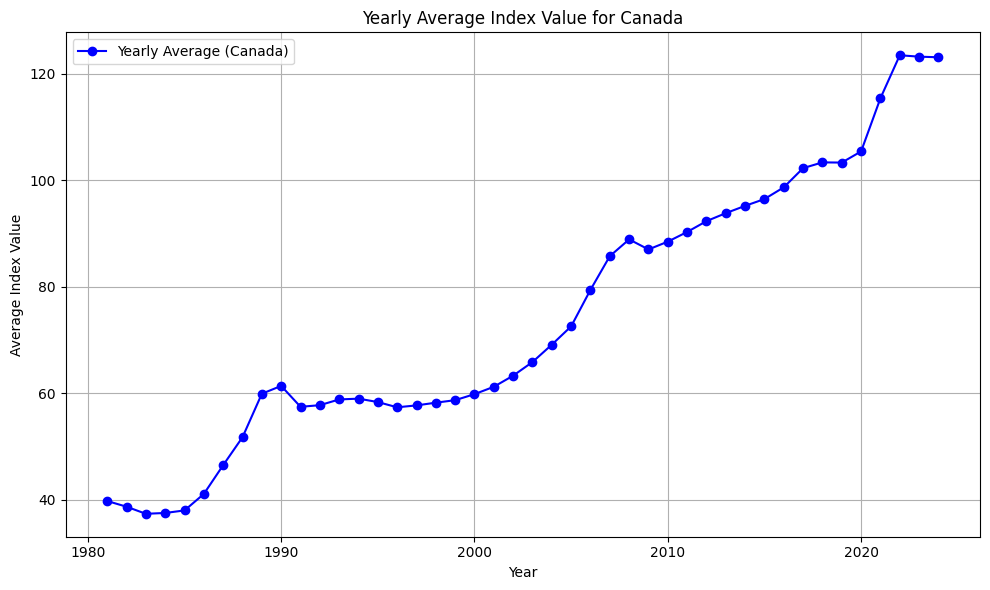

In [14]:
#GRAPHING THE MEAN NHPI (New Housing price Index) EACH YEAR IN CANADA


import matplotlib.pyplot as plt

# Create a copy of the dataframe
data1 = data.copy()

# Filter the DataFrame for rows where 'GEO' equals 'Canada'
canada_data = data1[data1['GEO'] == 'Canada'].copy()

# Convert 'REF_DATE' to datetime objects
canada_data['REF_DATE'] = pd.to_datetime(canada_data['REF_DATE'])

# Extract the year from the 'REF_DATE' column
canada_data['Year'] = canada_data['REF_DATE'].dt.year

# Group data by year and calculate the mean value for each year
yearly_data = canada_data.groupby('Year')['VALUE'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    yearly_data.index,
    yearly_data.values,
    marker='o',
    linestyle='-',
    color='b',
    label='Yearly Average (Canada)')

plt.xlabel('Year')
plt.ylabel('Average Index Value')
plt.title('Yearly Average Index Value for Canada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Anomalies:
Year
1990    61.397222
1991    57.475000
1994    59.005556
1996    57.383333
Name: VALUE, dtype: float64


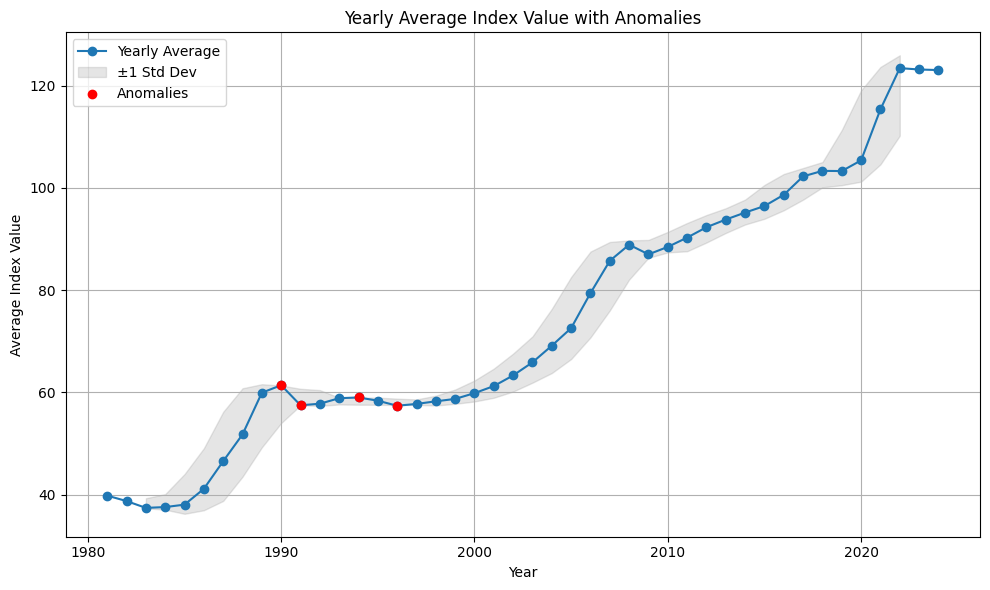

In [15]:
#FINDING ANY ANOMALIES

# Calculate rolling mean and standard deviation
rolling_mean = yearly_data.rolling(window=5, center=True).mean()
rolling_std = yearly_data.rolling(window=5, center=True).std()

# Define anomaly threshold (e.g., 2 times the rolling standard deviation)
upper_bound = rolling_mean + 1 * rolling_std
lower_bound = rolling_mean - 1 * rolling_std

# Identify anomalies
anomalies = yearly_data[(yearly_data > upper_bound) | (yearly_data < lower_bound)]

print("Anomalies:")
print(anomalies)

# Plot with bounds
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data.values, marker='o', linestyle='-', label='Yearly Average')
plt.fill_between(yearly_data.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='±1 Std Dev')
plt.scatter(anomalies.index, anomalies.values, color='r', label='Anomalies', zorder=5)
plt.xlabel('Year')
plt.ylabel('Average Index Value')
plt.title('Yearly Average Index Value with Anomalies')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
canada_data.head()

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,Year
0,1981-01-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1,1981
1,1981-01-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1,1981
2,1981-01-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,E,NaN,NaN,1,1981
120,1981-02-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.7,NaN,NaN,NaN,1,1981
121,1981-02-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.5,NaN,NaN,NaN,1,1981


In [22]:
#before checking seasonal trends lets ensure the data for each month is equal


#Step 1: Extract the month from the 'REF_DATE' column
canada_data['Month'] = canada_data['REF_DATE'].dt.month

#STEP 2: Group the data by month and count the occurrences
monthly_counts = canada_data.groupby('Month')['VALUE'].count()


# Print the monthly counts
print(monthly_counts)



Month
1     132
2     132
3     132
4     132
5     132
6     132
7     132
8     132
9     132
10    132
11    132
12    132
Name: VALUE, dtype: int64


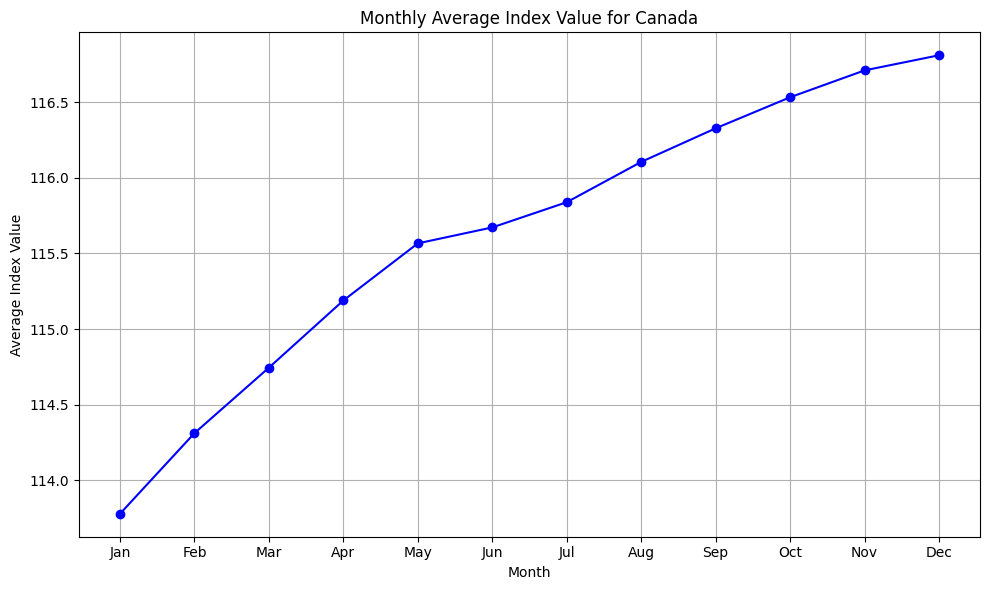

Month(s) with the highest average value: [12]


In [26]:
#DETECT SEASONAL TRENDS

#To minimize potential bias from older data that could skew the average, we'll focus on the most recent five years (2019–2024)

#create a new dataframe for the last 5 years
canada_data_last_5_years = canada_data[canada_data['Year'] >= 2019]

# Group data by month and calculate the mean value
monthly_data = canada_data_last_5_years.groupby('Month')['VALUE'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Average Index Value')
plt.title('Monthly Average Index Value for Canada')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the month(s) with the highest value
max_value = monthly_data.max()
months_with_highest_value = monthly_data[monthly_data == max_value].index.tolist()
print(f"Month(s) with the highest average value: {months_with_highest_value}")

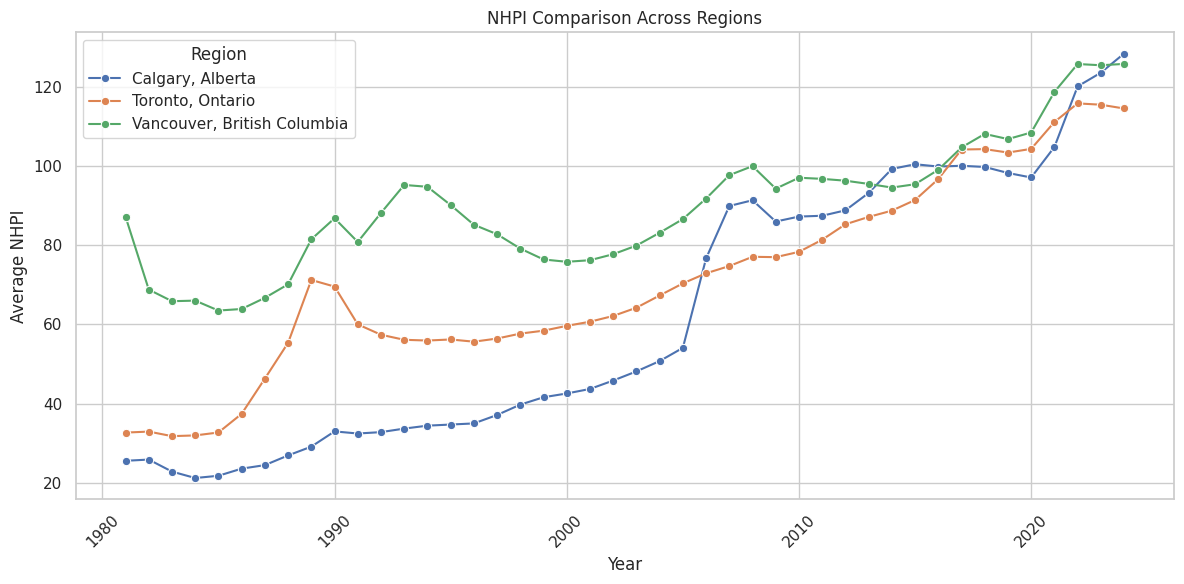

In [27]:
#Comparing NHPI between 3 major cities in Canada (Vancouver, Toronto, Calgary)


data1['REF_DATE'] = pd.to_datetime(data1['REF_DATE'])

data1['Year'] = data1['REF_DATE'].dt.year
data1['Month'] = data1['REF_DATE'].dt.month



data_grouped = data1.groupby(['GEO', 'Year'])['VALUE'].mean().reset_index()

# Define the list of GEO values you want to include
geo_values = ['Toronto, Ontario', 'Vancouver, British Columbia', 'Calgary, Alberta']

# Filter data_grouped using isin()
data_grouped = data_grouped[data_grouped['GEO'].isin(geo_values)]


import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Create the plot comparing NHPI across regions by year
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='VALUE', hue='GEO', data=data_grouped, marker='o')

# Customize the plot
plt.title('NHPI Comparison Across Regions')
plt.xlabel('Year')
plt.ylabel('Average NHPI')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()

# Show the plot
plt.show()


